In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pymongo


%matplotlib inline
# matplotlib.rcParams["figure.figsize"] = (20.0, 14.0)
# matplotlib.rcParams["font.size"] = 26
# matplotlib.rcParams["axes.grid"] = True
# matplotlib.rcParams["axes.facecolor"] = (0.97,0.97,0.97)

In [2]:
client = pymongo.MongoClient()
db = client.swatford

In [3]:
gene_uid = pd.read_pickle("../data/SSI/gene_uid.p")

In [342]:
gene_uid_o = pd.read_pickle("../data/SSI/gene_uid_original.p")

In [43]:
%run ../scripts/equations.py

In [44]:
n = db.genes.descs.original.find().count()

In [45]:
gene_uid["pmi"] = pmi(gene_uid.gd_freq.values,gene_uid.d_freq.values,gene_uid.g_freq.values,n)
gene_uid["npmi"] = npmi(gene_uid.pmi.values,gene_uid.gd_freq.values,n)

In [343]:
gene_uid_o["pmi"] = pmi(gene_uid_o.gd_freq.values,gene_uid_o.d_freq.values,gene_uid_o.g_freq.values,n)
gene_uid_o["npmi"] = npmi(gene_uid_o.pmi.values,gene_uid_o.gd_freq.values,n)

In [4]:
bc_uids = ["D009389","D018919","D017209","D002453","D057890","D004249","D004260","D013006","D002470","D007107",
    "D007249","D001940","D001941","D018384","D049109","D012739","D015262"]

In [5]:
bc_genes = pd.read_pickle("../data/SSI/ssi_gene_list.p")

In [35]:
# bc_results = gene_uid[gene_uid.uid.isin(bc_uids)].groupby("uid").gene_id.apply(set)
# bc_results = gene_uid[(gene_uid.uid.isin(bc_uids)) & (gene_uid.gene_id.isin(bc_genes))].groupby("uid").gene_id.apply(set)
# bc_results = bc_results.apply(lambda x: set(bc_genes) & set(x))

In [7]:
desc_children = pd.Series({doc["uid"]:db.medline.descs.distinct("uid",{"ancestors":{"$in":doc["tn"]}})
               for doc in db.medline.descs.find({"uid":{"$in":bc_uids}})})
desc_children_count = desc_children.apply(len)

In [354]:
bc_results = {}
bc_results_gt0 = {}

for tup in desc_children.iteritems():
#     bc_results[tup[0]] = set(bc_genes) & set(gene_uid_o[gene_uid_o.uid.isin(tup[1] + [tup[0]]) ].gene_id)
    bc_results[tup[0]] = set(bc_genes) & set(gene_uid_o[(gene_uid_o.uid.isin(tup[1] + [tup[0]])) 
                                                      & (gene_uid_o.npmi>0.0)].gene_id)
    bc_results_gt0[tup[0]] = set(bc_genes) & set(gene_uid[(gene_uid.uid.isin(tup[1] + [tup[0]])) 
                                                      & (gene_uid.npmi>0.0)].gene_id)
    print(tup[0])
bc_results = pd.Series(bc_results)
bc_results_gt0 = pd.Series(bc_results_gt0)

D001940
D001941
D002453
D002470
D004249
D004260
D007107
D007249
D009389
D012739
D013006
D015262
D017209
D018384
D018919
D049109
D057890


In [365]:
for uid in bc_uids:
    bc_results[uid] = set(bc_genes) & set(gene_uid_o[(gene_uid_o.uid.isin([uid])) 
                                                          & (gene_uid_o.npmi>0.0)].gene_id)
    bc_results_gt0[uid] = set(bc_genes) & set(gene_uid[(gene_uid.uid.isin([uid])) 
                                                  & (gene_uid.npmi>0.0)].gene_id)
bc_results = pd.Series(bc_results)
bc_results_gt0 = pd.Series(bc_results_gt0)

In [368]:
bc_results.apply(len)

D001940    155
D001941     31
D002453     86
D002470    156
D004249     78
D004260     48
D007107     84
D007249    101
D009389    116
D012739    108
D013006     65
D015262    101
D017209    121
D018384    108
D018919     98
D049109    160
D057890     50
dtype: int64

In [369]:
bc_results_gt0.apply(len)

D001940    127
D001941      0
D002453     29
D002470    156
D004249     60
D004260     47
D007107      0
D007249     81
D009389    107
D012739      8
D013006     43
D015262    101
D017209    120
D018384    106
D018919     98
D049109    131
D057890     50
dtype: int64

In [370]:
data = []
for uid in bc_results.index.values:
    uid_data = {}
    for uid2 in bc_results.index.values:
        if bc_results.apply(len)[uid]>0 and bc_results.apply(len)[uid2]>0:
            uid_data[uid2] = len(bc_results[uid] & bc_results[uid2])/len(bc_results[uid] | bc_results[uid2])
        else:
            uid_data[uid2] = 0
    data.append(pd.Series(uid_data,name=uid))
data_gt0 = []
for uid in bc_results_gt0.index.values:
    uid_data = {}
    for uid2 in bc_results_gt0.index.values:
        if bc_results_gt0.apply(len)[uid]>0 and bc_results_gt0.apply(len)[uid2]>0:
            uid_data[uid2] = len(bc_results_gt0[uid] & bc_results_gt0[uid2])/len(bc_results_gt0[uid] | bc_results_gt0[uid2])
        else:
            uid_data[uid2] = 0
    data_gt0.append(pd.Series(uid_data,name=uid))

In [371]:
mat = pd.DataFrame(data)
mat_gt0 = pd.DataFrame(data_gt0)

In [372]:
desc_name_map = pd.Series({doc["uid"]:doc["name"] for doc in db.medline.descs.find()})

In [373]:
# sort the same way: by total number of genes retrieved without a cutoff
sort_by_gene = bc_results.apply(len).sort_values(ascending=False).index.values
# mat = mat[bc_results.apply(len).sort_values(
#     ascending=False).index].loc[bc_results.apply(len).sort_values(ascending=False).index].copy()
# mat_gt0 = mat_gt0[bc_results.apply(len).sort_values(
#     ascending=False).index].loc[bc_results.apply(len).sort_values(ascending=False).index].copy()

In [374]:
mat.columns = pd.Series(mat.columns).map(desc_name_map).values
mat.index = pd.Series(mat.index).map(desc_name_map).values
mat_gt0.columns = pd.Series(mat_gt0.columns).map(desc_name_map).values
mat_gt0.index = pd.Series(mat_gt0.index).map(desc_name_map).values

In [375]:
data_h1 = pd.DataFrame(mat.stack())
data_h1["method"] = ["no NPMI cutoff"]*len(data_h1)
data_h1["x"] = data_h1.index.get_level_values(0)
data_h1["y"] = data_h1.index.get_level_values(1)
data_h1.index = list(range(len(data_h1)))

In [376]:
data_h2 = pd.DataFrame(mat_gt0.stack())
data_h2["method"] = ["NPMI>0.0"]*len(data_h2)
data_h2["x"] = data_h2.index.get_level_values(0)
data_h2["y"] = data_h2.index.get_level_values(1)
data_h2.index = list(range(len(data_h2)))

In [377]:
data = pd.concat([data_h1,data_h2])

/home/swatford/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


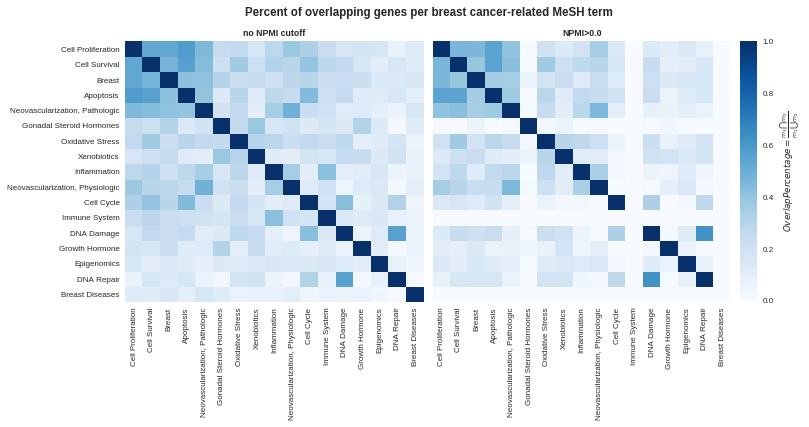

In [378]:
# sns.set_context("paper")
def facet_heatmap(data,color, **kws):
    data = data.pivot(index="y",
                      columns="x",
                      values=0)[desc_name_map[sort_by_gene].values].loc[desc_name_map[sort_by_gene].values]
    sns.heatmap(data,cmap="Blues", **kws)


g = sns.FacetGrid(data, col="method", size=6, aspect=1)

cbar_ax = g.fig.add_axes([0.86, .3, .02, .6])
# cbar_ax.yaxis.set_label(r"$Overlap Percentage=\frac{m_1\bigcap m_2}{m_1\bigcup m_2}$")
g = g.map_dataframe(facet_heatmap, 
                    cbar_ax=cbar_ax,
                    cbar_kws={"label":r"$Overlap Percentage=\frac{m_1\bigcap m_2}{m_1\bigcup m_2}$"},
                    vmin=0, vmax=1,
                    cbar=True)
g.set_titles(col_template="{col_name}", fontweight='bold')
g.fig.subplots_adjust(top=0.9,right=.85)
# plt.title("Percent of overlapping genes per MeSH term")
g.fig.suptitle("""Percent of overlapping genes per breast cancer-related MeSH term""",fontweight="bold")
plt.savefig("heatmap.png",dpi=500,transparent=True,bbox_inches="tight")